# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import LUCI.LuciPlotting as lplt
import keras

2023-01-31 12:03:38.874381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-01-31 12:03:38.874401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [2, 1, 0.3, 0.15, 0.25]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 20  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 50

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [3]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [1]  # Just randomly chosen
velocity = 200  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [4]:
# And we can now take a look

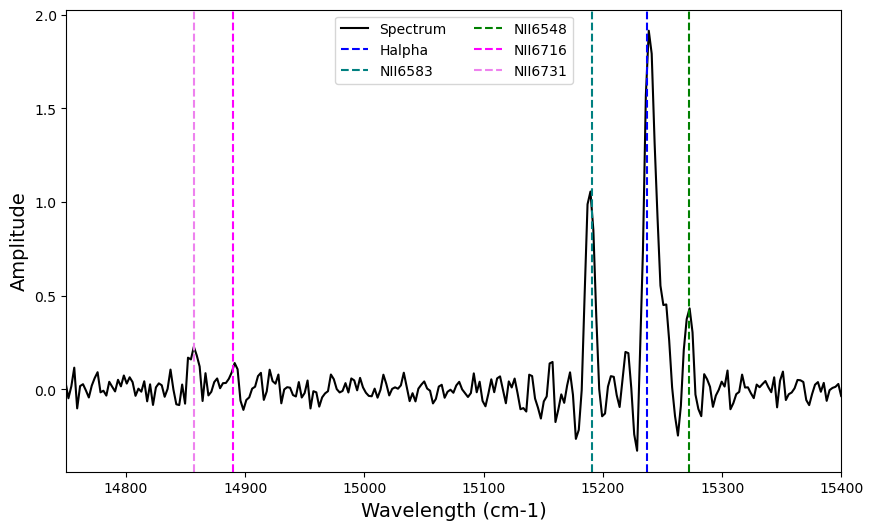

In [5]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale


2023-01-31 12:03:44.554185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-01-31 12:03:44.554215: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 12:03:44.554257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-01-31 12:03:44.554448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<AxesSubplot:xlabel='Wavelength [cm-1]', ylabel='Flux [ergs s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]'>

<Figure size 640x480 with 0 Axes>

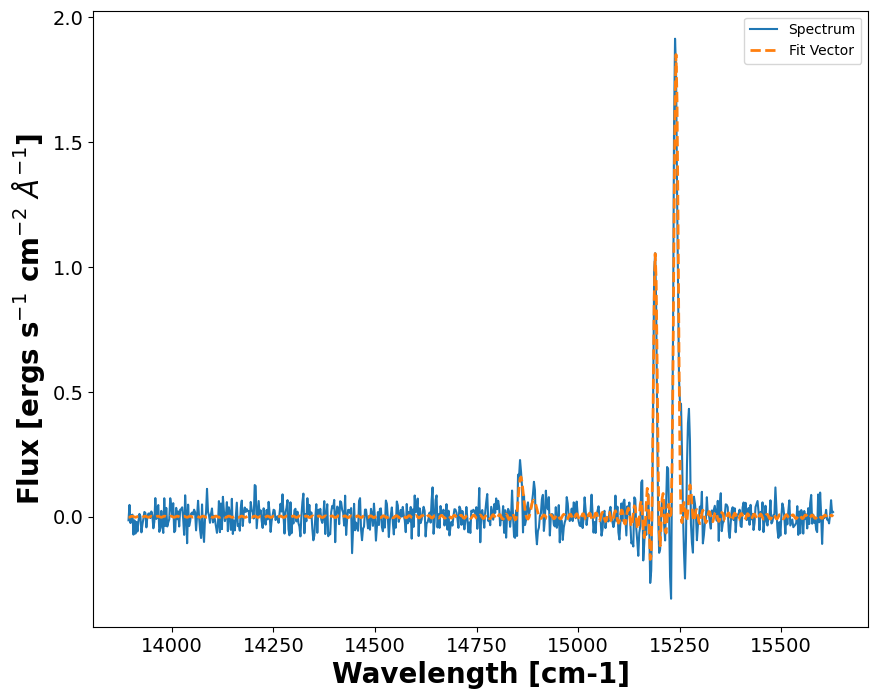

In [7]:
fit = lfit.Fit(spectrum.astype(np.double), spectrum_axis.astype(np.double), wavenumbers_syn, 'sincgauss', 
               ['Halpha', 'Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               [1,2,1,1,1,1], [1,2,1,1,1,1],
               #['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               #[1,1,1,1,1], [1,1,1,1,1], 
               keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3'),
               bayes_bool=False, #, uncertainty_bool=True
               n_stoch=1,
               #spec_min=14750, spec_max=15350
               )
fit_dict = fit.fit()
lplt.plot_fit(spectrum_axis, spectrum, fit_dict['fit_vector'])

In [8]:
fit_dict

{'fit_sol': array([ 1.80914191e+00,  1.52400108e+04,  4.71709695e+00,  7.94686255e-01,
         1.51885864e+04, -1.11763559e-06,  2.59487306e-01,  1.51923005e+04,
         4.70232962e+00,  8.61597269e-02,  1.52743868e+04,  4.72773702e+00,
         7.21837600e-02,  1.48913258e+04,  4.60917176e+00,  1.64042870e-01,
         1.48595115e+04,  4.59932458e+00, -1.91409369e-08]),
 'fit_uncertainties': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'amplitudes': [1.8091419084079032,
  0.7946862548967653,
  0.25948730633752753,
  0.08615972690483378,
  0.07218375996376758,
  0.1640428703176947],
 'fluxes': [3.7186280098575244,
  1.0280294761789255,
  0.5321618115313532,
  0.1773872705104527,
  0.14594005965339069,
  0.33116044613168266],
 'flux_errors': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'chi2': 0.10462759473727958,
 'velocities': [-51.38450550289837,
  963.4562873374897,
  -51.38450550300234,
  -51.38450550295026,
  -51.38450550288783,
  -51.3845055